# Prerequisite

In [1]:
import faiss
import numpy as np
import im2gps.services.localisation as localisation

from im2gps.lib.index import IndexBuilder, IndexType
from im2gps.lib.localisation import LocalisationType
from im2gps.data.descriptors import DescriptorsTable
from im2gps.conf.config import load_config

Load databases

In [2]:
cfg = load_config(["../config-local.yaml"])
path_to_db = cfg.data.datasets.train
path_to_queries = cfg.data.datasets.validation_queries

db = DescriptorsTable(path_to_db, 2048)
val_queries = DescriptorsTable(path_to_queries, 2048)
db_coords = np.array([[desc.lat, desc.lon] for desc in db])
q_coords = np.array([[desc.lat, desc.lon] for desc in val_queries])
queries_array = np.array([q.descriptor for q in val_queries]).astype('float32')

In [32]:
db.close()
val_queries.close()

Prepare functions for grid search

In [2]:
import tqdm.contrib.itertools as itertools
import json

def save_results(results, output_path):
    with open(output_path, 'w') as f:
        json.dump(results, f)

def get_results(data, **kwargs):
    locations = localisation.localise(queries=data, **kwargs)
    accuracy, err, _ = localisation.compute_statistics(kwargs['q_coords'], locations)
    results = {
        'accuracy' : accuracy,
        'error': err
    }
    return results

def grid_search(data, parameters_grid: dict, get_results, **kwargs):
    keys = parameters_grid.keys()
    vals = list(parameters_grid.values())
    results = []
    for params in itertools.product(*vals):
        params_dict = {}
        for k,v in zip(keys, params):
            params_dict[k]=v
            kwargs[k]=v
        iter_results = get_results(data, **kwargs)
        results.append({'parameters': params_dict, 'results': iter_results})
    return results

In [7]:
import random
from tqdm import tqdm


def randomised_grid_search(data, parameters_grid: dict, num_trials, get_results, **kwargs):
    # 1. randomly select num_trial parameters for each parameter in param_grid
    chosen_params = {}
    for p_name, p_values in parameters_grid.items():
        chosen_params[p_name] = random.choices(p_values, k=num_trials)
    results = []
    for i in tqdm(range(num_trials)):
        p_dict = {}
        for p_name, p_vals in chosen_params.items():
            if isinstance(p_vals, np.ndarray):
                val = p_vals[i].item()
            else:
                val = p_vals[i]
            p_dict[p_name] = val
            kwargs[p_name] = val
#         print(kwargs, type(kwargs['k']), type(kwargs['sigma']), type(kwargs['m'])) 
        iter_results = get_results(data, **kwargs)
        results.append({'parameters': p_dict, 'results': iter_results})
    return results

# Parameters finetuning

## Finetuning for L2 index

In [37]:
index = IndexBuilder(db, IndexType.L2_INDEX).build()

### KDE

In [35]:
grid = {
    'k': [2,5,7,10,15,20,30,50,80,100],
    'sigma': [0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01],
    'm': [1,3,5,7,10,15]
}
results=grid_search(queries_array, grid, get_results, index=index,db_coords=db_coords, index_type=IndexType.L2_INDEX, loc_type=LocalisationType.KDE.type_str, q_coords=q_coords)
save_results(results, '../output/kde_grid_s_1.json')

100%|██████████| 60/60 [1:22:52<00:00, 82.88s/it] 


### Weighted average

In [6]:
grid = {
    'k': [2,3,5,6,8,10,15,20,30,40,50,60,70,80,90,100],
    'm': [1,2,3,4,5,6,7,8,10,15,20]
}
    
results=grid_search(queries_array, grid, get_results, index=index,db_coords=db_coords, index_type=IndexType.L2_INDEX, loc_type=LocalisationType.AVG.type_str, avg_type='weighted',q_coords=q_coords)
save_results(results, '../output/weighted_avg_val_reults.json')

  0%|          | 0/176 [00:00<?, ?it/s]

### Simple average

In [5]:
grid = {
    'k': [2,3,5,6,8,10,15,20,30,40,50,60,70,80,90,100]
}
    
results=grid_search(queries_array, grid, get_results, index=index,db_coords=db_coords, index_type=IndexType.L2_INDEX, loc_type=LocalisationType.AVG.type_str, avg_type='regular',q_coords=q_coords)
save_results(results, '../output/simple_avg_val_reults.json')

  0%|          | 0/16 [00:00<?, ?it/s]

/Users/zakharca/Documents/Study/thesis/src/.env/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/zakharca/Documents/Study/thesis/src/.env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Finetuning on cosine index

In [3]:
index = IndexBuilder(db, IndexType.COSINE_INDEX).build()

In [4]:
faiss.normalize_L2(queries_array)

### KDE

In [ ]:
grid = {
    'k': [2,5,7,10,15,20,30,50,80,100],
    'sigma': [0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01],
    'm': [1,3,5,7,10,15]
}
results=grid_search(queries_array, grid, get_results, index=index,db_coords=db_coords, index_type=IndexType.COSINE_INDEX, loc_type=LocalisationType.KDE.type_str, q_coords=q_coords, preprocessed=True)
save_results(results, '../output/kde_grid_s_cosine_1.json')

  0%|          | 0/420 [00:00<?, ?it/s]

### Weighted average

In [8]:
grid = {
    'k': [2,3,5,6,8,10,15,20,30,40,50,60,70,80,90,100],
    'm': [1,2,3,4,5,6,7,8,10,15,20]
}
    
results=grid_search(queries_array, grid, get_results, index=index,db_coords=db_coords, index_type=IndexType.COSINE_INDEX, loc_type=LocalisationType.AVG.type_str, avg_type='weighted',q_coords=q_coords, preprocessed=True)
save_results(results, '../output/weighted_avg_cosine_1.json')

  0%|          | 0/176 [00:00<?, ?it/s]

/Users/zakharca/Documents/Study/thesis/src/.env/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/zakharca/Documents/Study/thesis/src/.env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Simple average

In [9]:
grid = {
    'k': [2,3,5,6,8,10,15,20,30,40,50,60,70,80,90,100]
}
    
results=grid_search(queries_array, grid, get_results, index=index,db_coords=db_coords, index_type=IndexType.COSINE_INDEX, loc_type=LocalisationType.AVG.type_str, avg_type='regular',q_coords=q_coords, preprocessed=True)
save_results(results, '../output/simp_avg_cosine_1.json')

  0%|          | 0/16 [00:00<?, ?it/s]

# Visualisation of results

## KDE with L2 index

In [3]:
with open("/Users/zakharca/Documents/Study/thesis/src/results/simple-localisation-params-finetuning/kde_grid_s_1.json", 'r') as f:
    kde_data = json.load(f)

In [4]:
from dataclasses import make_dataclass
import pandas as pd
data = []
Record = make_dataclass('Record', [('k', int), ('sigma', float), ('m', int), ('scale', str), ('accuracy', float)])
for it in kde_data:
    k=it['parameters']['k']
    s=it['parameters']['sigma']
    m=it['parameters']['m']
    for scale,acc in it['results']['accuracy'].items():
        data.append(Record(k,s,m,scale,acc))
kde_df = pd.DataFrame(data)


Let's have a look at max accuracy at different scale scale

In [5]:
max_accuracy = kde_df.groupby(['scale'])['accuracy'].transform(max) == kde_df['accuracy']
kde_df[max_accuracy]

,k,sigma,m,scale,accuracy
1604,15,0.0050,5,500m,0.389423
1653,15,0.0100,5,1km,0.478147
1835,20,0.0010,3,100m,0.230769
2376,50,0.0001,7,1m,0.003934
2696,80,0.0001,3,1m,0.003934
2843,80,0.0010,3,100m,0.230769
3033,100,0.0001,3,5m,0.017920
3034,100,0.0001,3,10m,0.040210
3064,100,0.0001,15,1m,0.003934
3179,100,0.0010,3,100m,0.230769


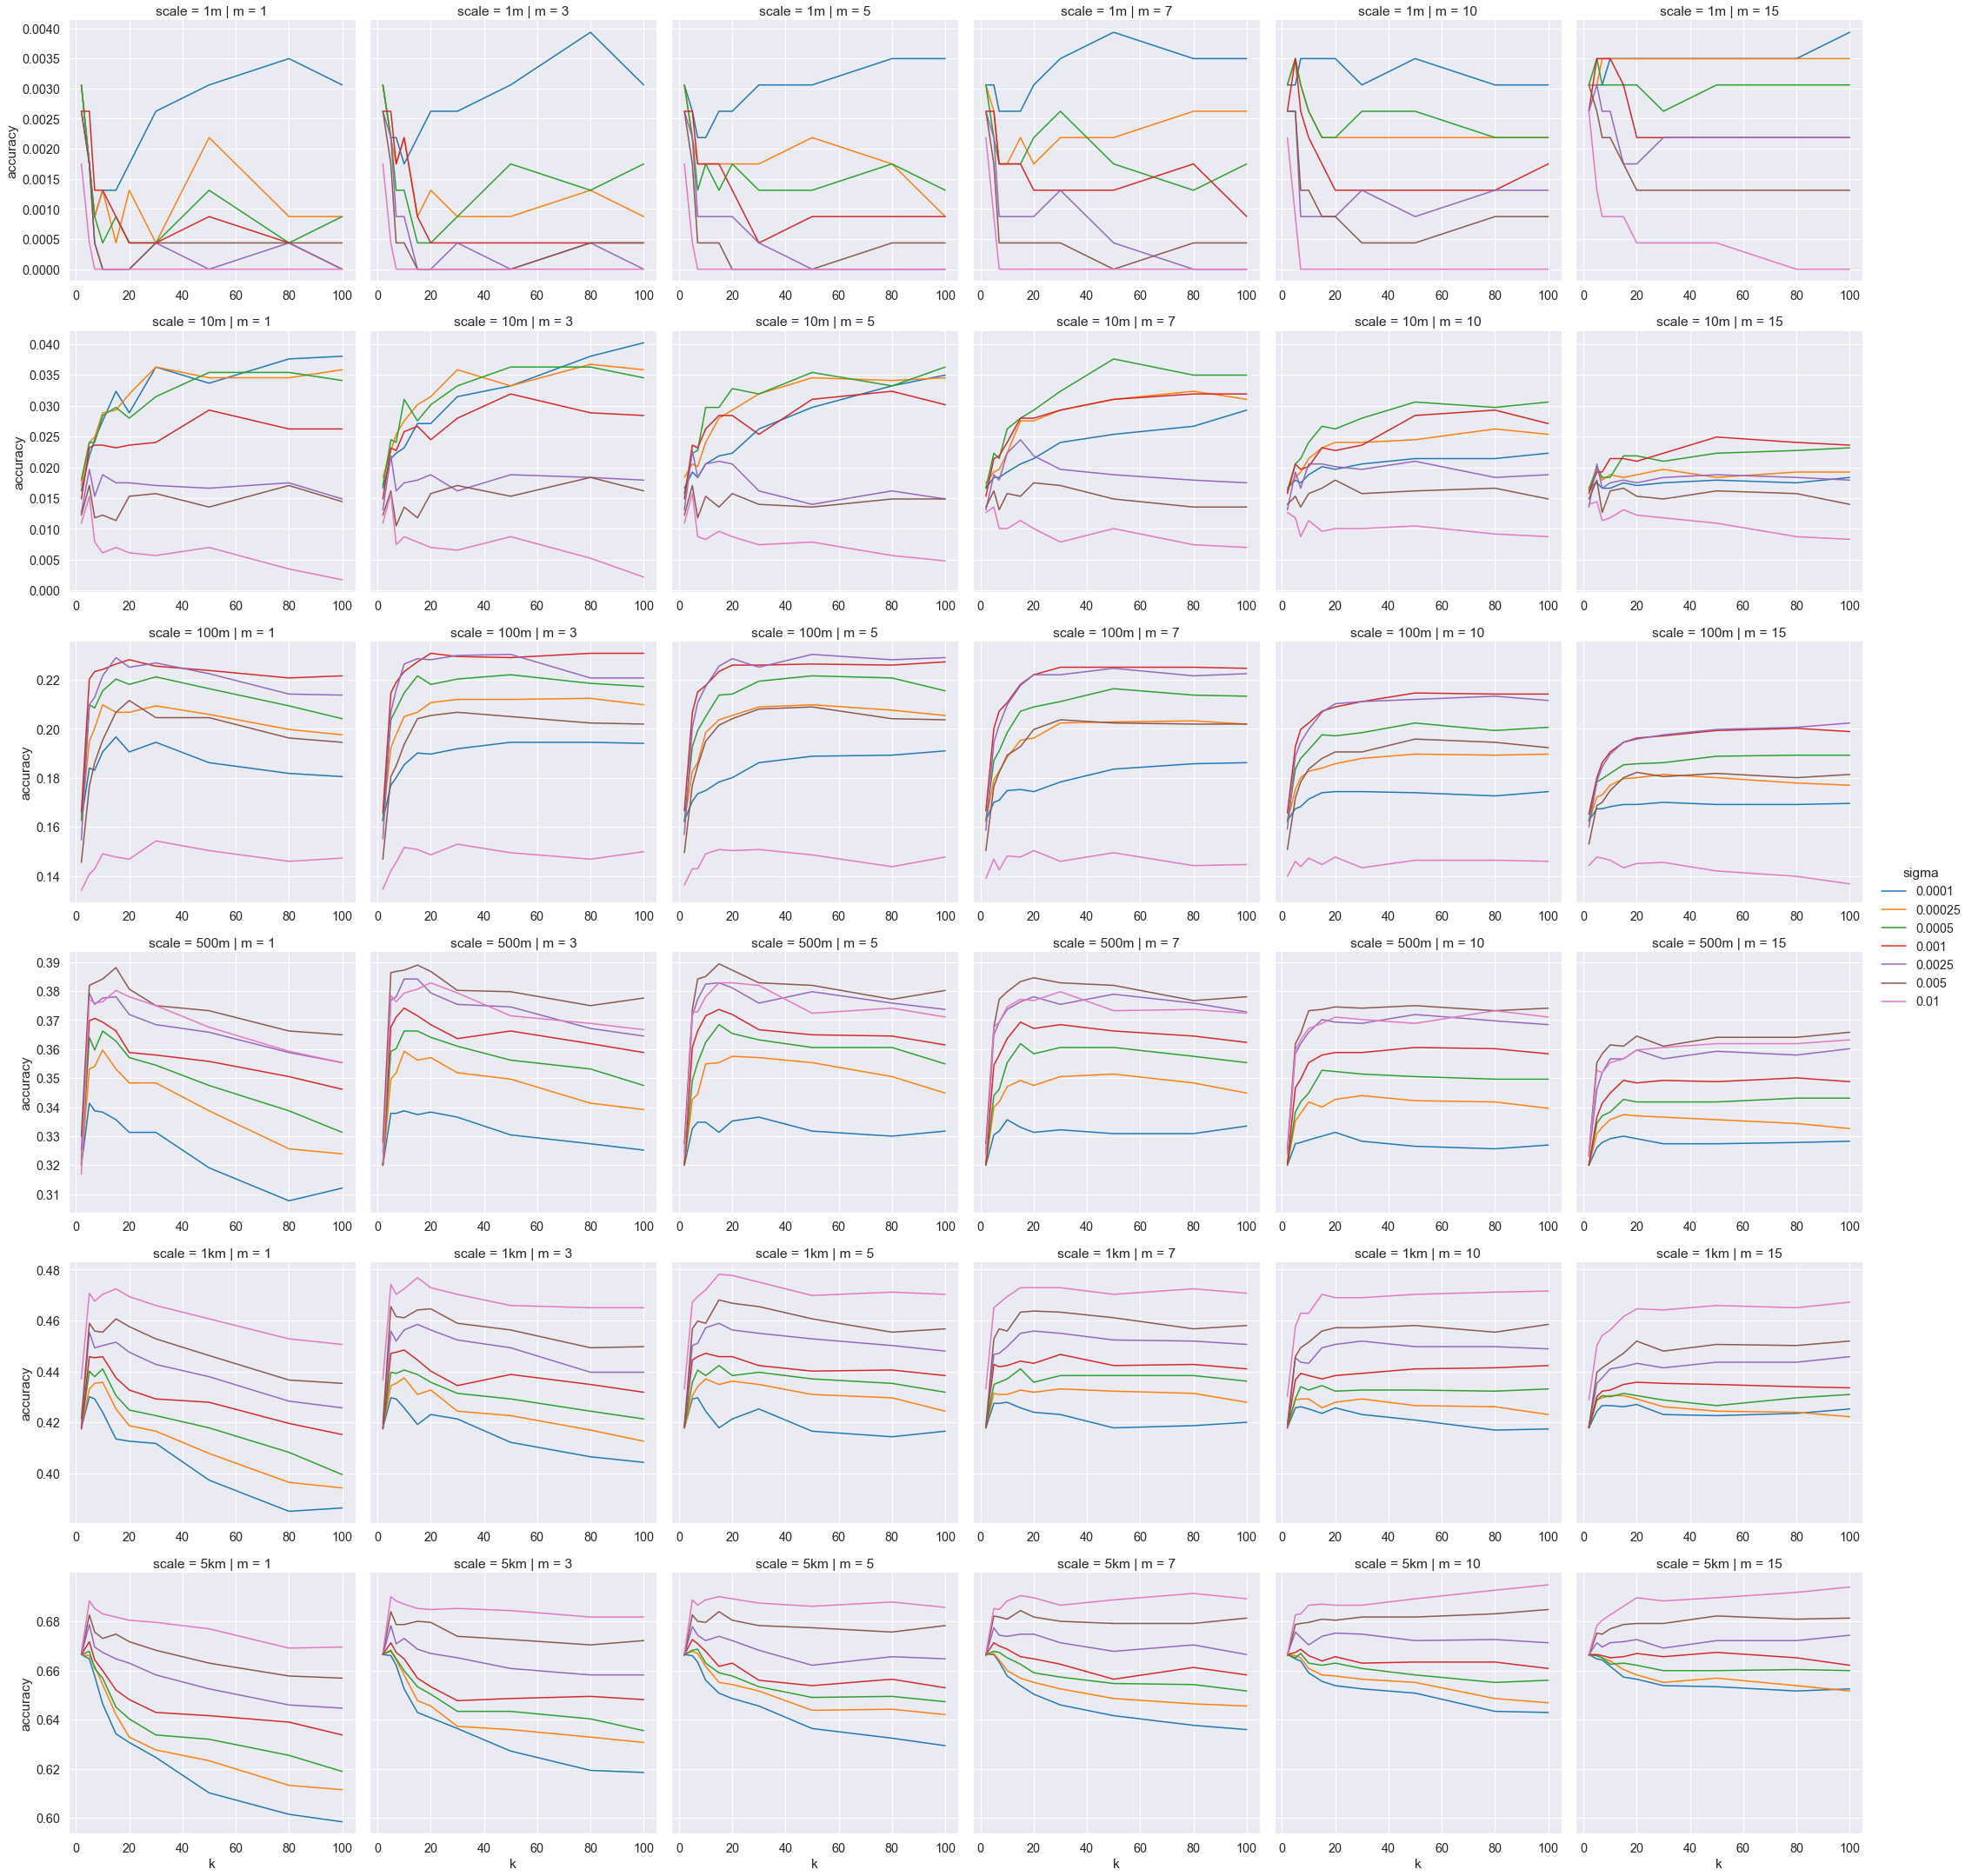

In [31]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.3)
tmp = kde_df.loc[(kde_df['scale']=='1m')|(kde_df['scale']=='10m')| (kde_df['scale']=='100m')| (kde_df['scale']=='500m') | (kde_df['scale']=='1km') | (kde_df['scale']=='5km')]
g= sns.relplot(
    data=tmp,
    x='k', y='accuracy', col='m', row='scale', hue='sigma',
    kind='line', facet_kws={'sharey':'row', 'sharex':False},
    palette=sns.color_palette('tab10',7),
)

Graph above shows accuracy (y-axis) on different scales (rows of the graph) with respect to different combination of parameters k (x-axis), sigma (lines with different colors) and m (columns in the graph). We can see that on a smaller scales (up to 500m) better value for m is between 3 and 5, for values of m greater than 5 accuracy starts to worsen. Best value for k depends on a scale on which we want to measure accuracy. For 10m scale it seems that choosing greater k (more than 80) can lead to better accuracy, for 100m scale optimal accuracy can be achieved for vaules 20 and greater, while for scale 500m and more optimal value for k is around 15. Also different sigma strongly determines accuracy on different scales, this can be seen better on the next plot.

/Users/zakharca/Documents/Study/thesis/src/.env/lib/python3.7/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


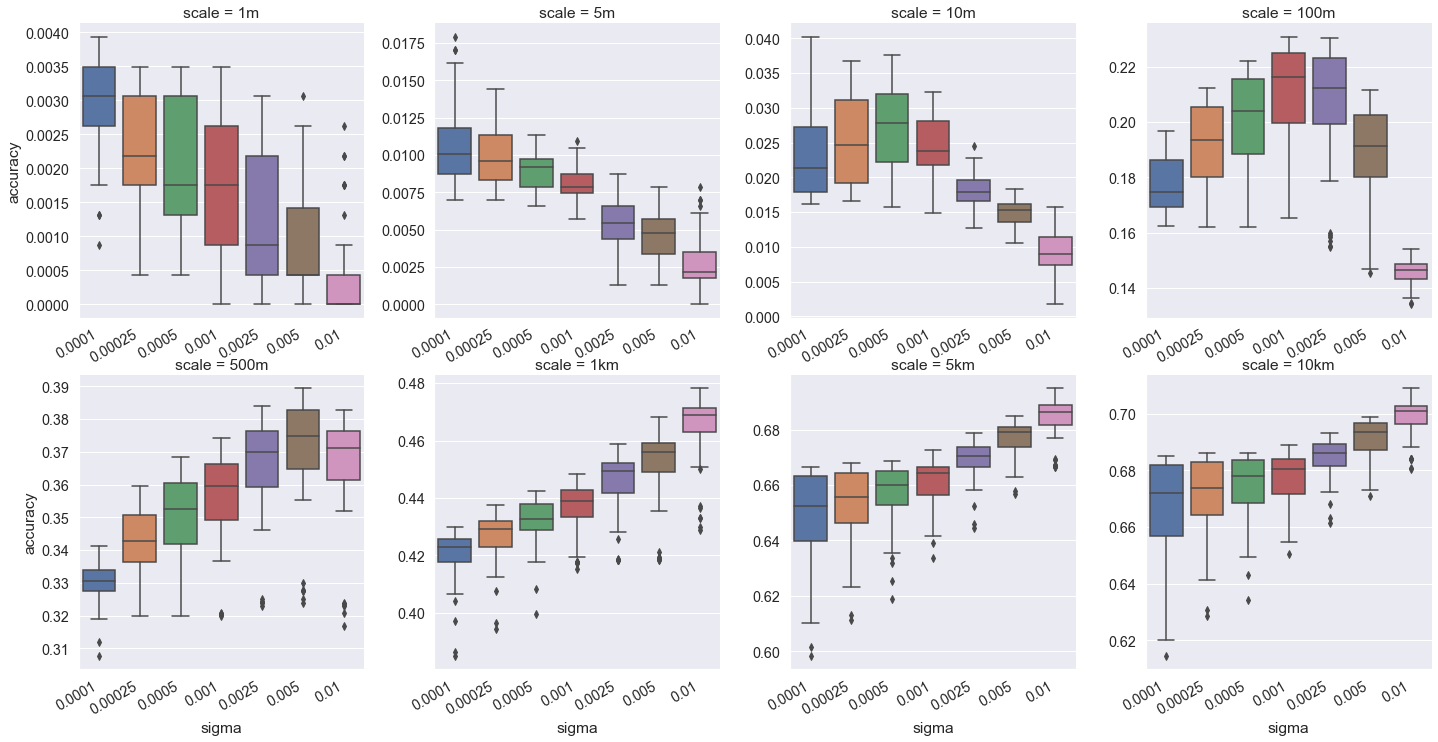

In [32]:
g=sns.catplot(data=kde_df, x='sigma', y='accuracy', col='scale', col_wrap=4, sharey=False, sharex=False, kind='box')
g.set_xticklabels(rotation=30, ha='right')

On the plot above we display accuracy on different scales depending on different choices of sigma. We can that for each scale there is different optimal sigma.

## KDE with cosine index

In [7]:
with open("/Users/zakharca/Documents/Study/thesis/src/results/simple-localisation-params-finetuning/kde_grid_s_cosine_1.json", 'r') as f:
    kde_data_cos = json.load(f)

In [8]:
data = []
Record = make_dataclass('Record', [('k', int), ('sigma', float), ('m', int), ('scale', str), ('accuracy', float)])
for it in kde_data_cos:
    k=it['parameters']['k']
    s=it['parameters']['sigma']
    m=it['parameters']['m']
    for scale,acc in it['results']['accuracy'].items():
        data.append(Record(k,s,m,scale,acc))
kde_df_cos = pd.DataFrame(data)

In [10]:
max_accuracy = kde_df_cos.groupby(['scale'])['accuracy'].transform(max) == kde_df_cos['accuracy']
kde_df_cos[max_accuracy]

,k,sigma,m,scale,accuracy
1669,15,0.0100,10,1km,0.478584
1679,15,0.0100,15,10km,0.704545
1964,20,0.0050,15,500m,0.391171
2251,30,0.0025,15,100m,0.235577
2392,50,0.0001,15,1m,0.003934
2689,80,0.0001,1,5m,0.017920
2712,80,0.0001,7,1m,0.003934
2720,80,0.0001,10,1m,0.003934
2728,80,0.0001,15,1m,0.003934
3022,80,0.0100,15,5km,0.691434


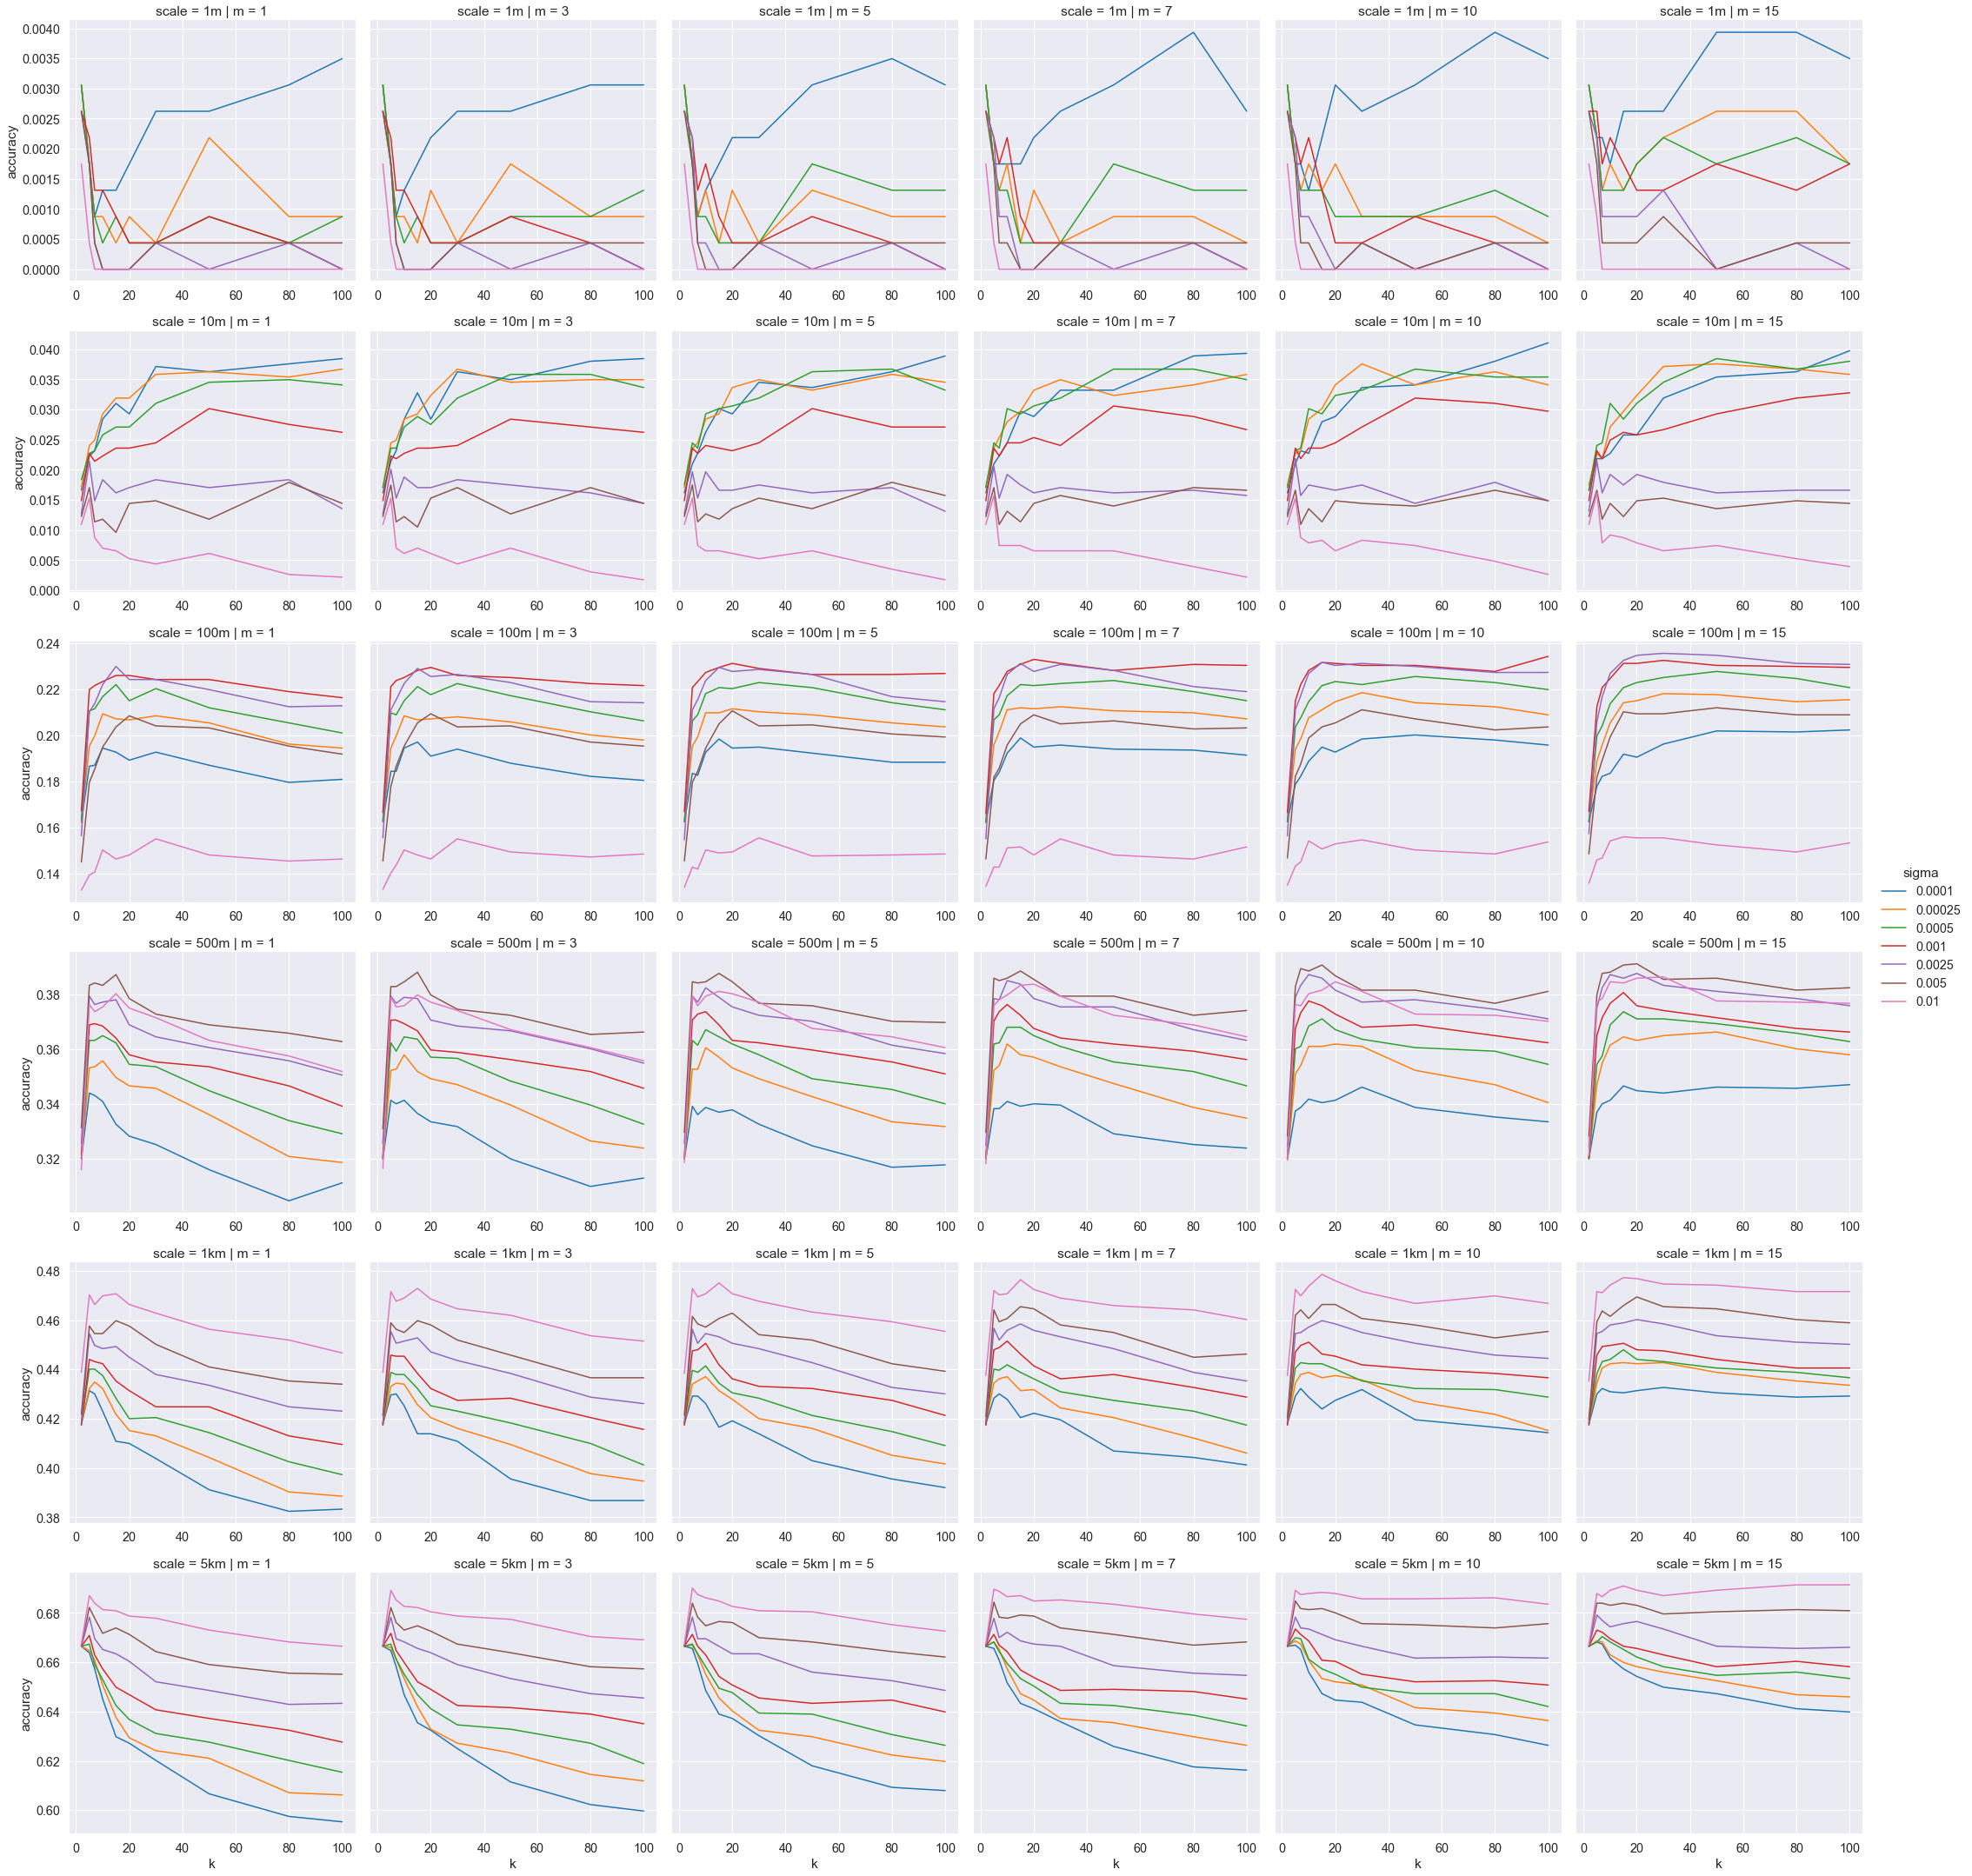

In [30]:
sns.set_style('darkgrid')
sns.set(font_scale=1.3)

tmp = kde_df_cos.loc[(kde_df_cos['scale']=='1m')|(kde_df_cos['scale']=='10m')| (kde_df_cos['scale']=='100m')| (kde_df_cos['scale']=='500m') | (kde_df_cos['scale']=='1km') | (kde_df_cos['scale']=='5km')]
g= sns.relplot(
    data=tmp,
    x='k', y='accuracy', col='m', row='scale', hue='sigma',
    kind='line', facet_kws={'sharey':'row', 'sharex':False},
    palette=sns.color_palette('tab10',7),
)

/Users/zakharca/Documents/Study/thesis/src/.env/lib/python3.7/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


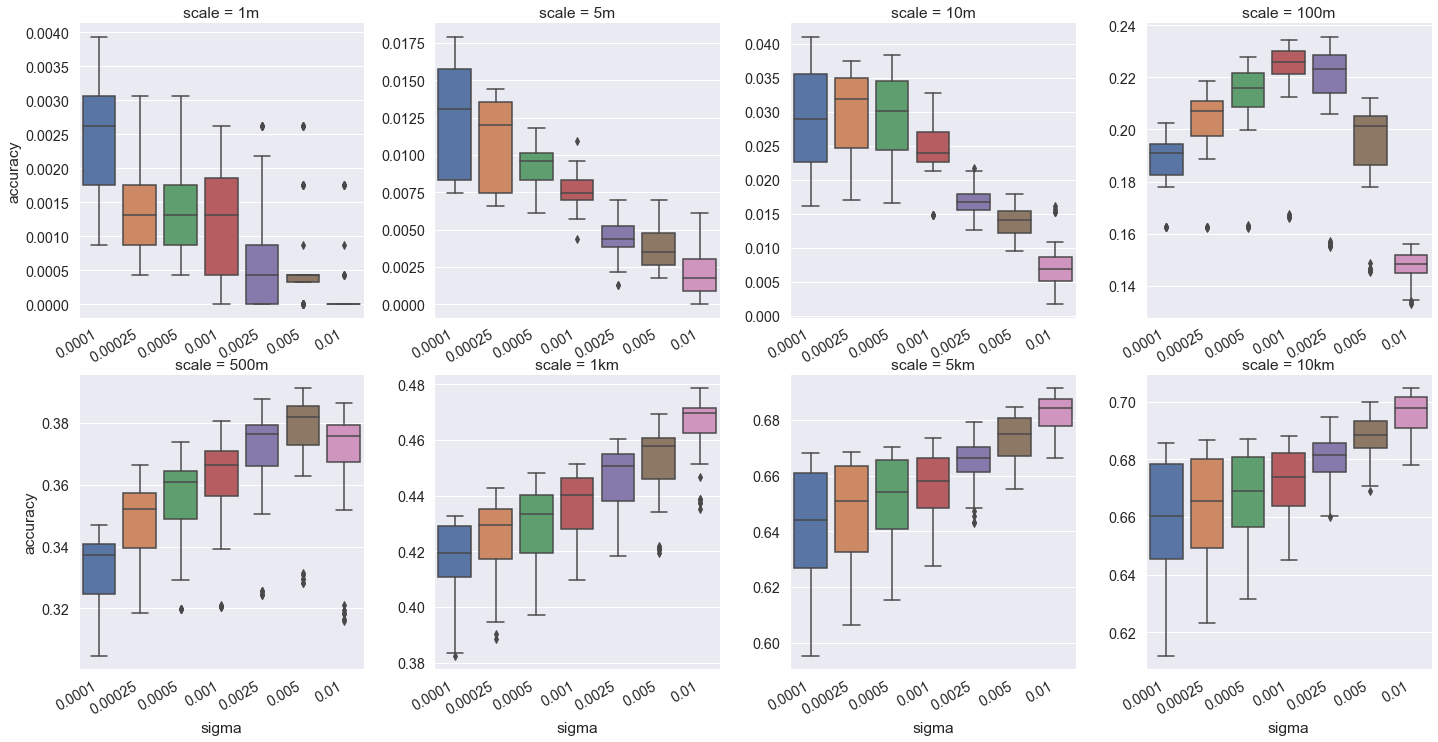

In [34]:
g=sns.catplot(data=kde_df_cos, x='sigma', y='accuracy', col='scale', col_wrap=4, sharey=False, sharex=False, kind='box')
g.set_xticklabels(rotation=30, ha='right')

## Simple average with L2 index

In [46]:
with open("/Users/zakharca/Documents/Study/thesis/src/results/simple-localisation-params-finetuning/simple_avg_val_reults.json", 'r') as f:
    avg_data = json.load(f)

In [47]:
data = []
Record = make_dataclass('Record', [('k', int), ('scale', str), ('accuracy', float)])
for it in avg_data:
    k=it['parameters']['k']
    for scale,acc in it['results']['accuracy'].items():
        data.append(Record(k,scale,acc))
avg_df = pd.DataFrame(data)

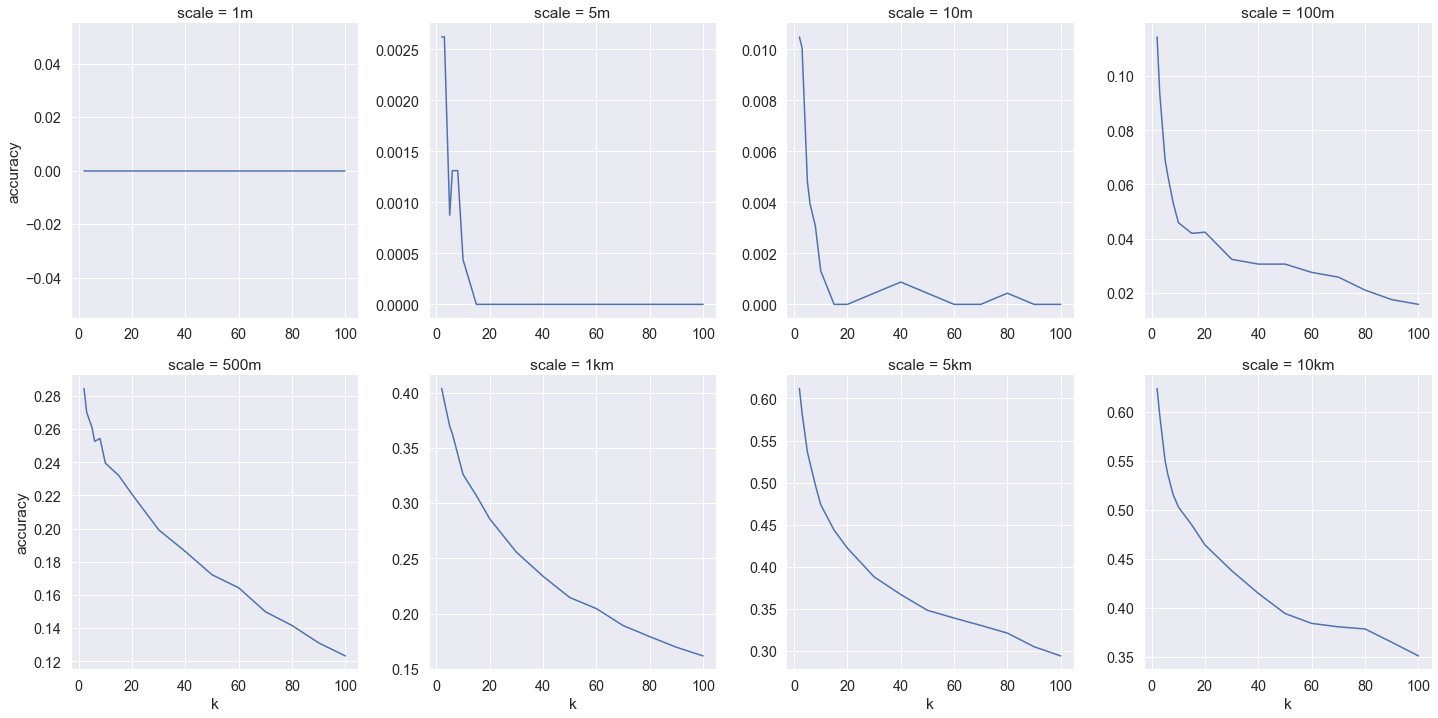

In [48]:
g= sns.relplot(
    data=avg_df,
    x='k', y='accuracy', col='scale', col_wrap=4,
    kind='line', facet_kws={'sharey':False, 'sharex':False},
    palette=sns.color_palette('tab10',7),
)

In [78]:
max_accuracy = avg_df.groupby(['scale'])['accuracy'].transform(max) == avg_df['accuracy']
avg_df[max_accuracy]

,k,scale,accuracy
0,2,1m,0.000000
1,2,5m,0.002622
2,2,10m,0.010490
3,2,100m,0.114510
4,2,500m,0.284528
5,2,1km,0.403846
6,2,5km,0.611888
7,2,10km,0.624126
8,3,1m,0.000000
9,3,5m,0.002622


## Simple average with Cosine index

In [74]:
with open("/Users/zakharca/Documents/Study/thesis/src/results/simple-localisation-params-finetuning/simp_avg_cosine_1.json", 'r') as f:
    avg_data_cos = json.load(f)

In [75]:
data = []
Record = make_dataclass('Record', [('k', int), ('scale', str), ('accuracy', float)])
for it in avg_data_cos:
    k=it['parameters']['k']
    for scale,acc in it['results']['accuracy'].items():
        data.append(Record(k,scale,acc))
avg_df_cos = pd.DataFrame(data)

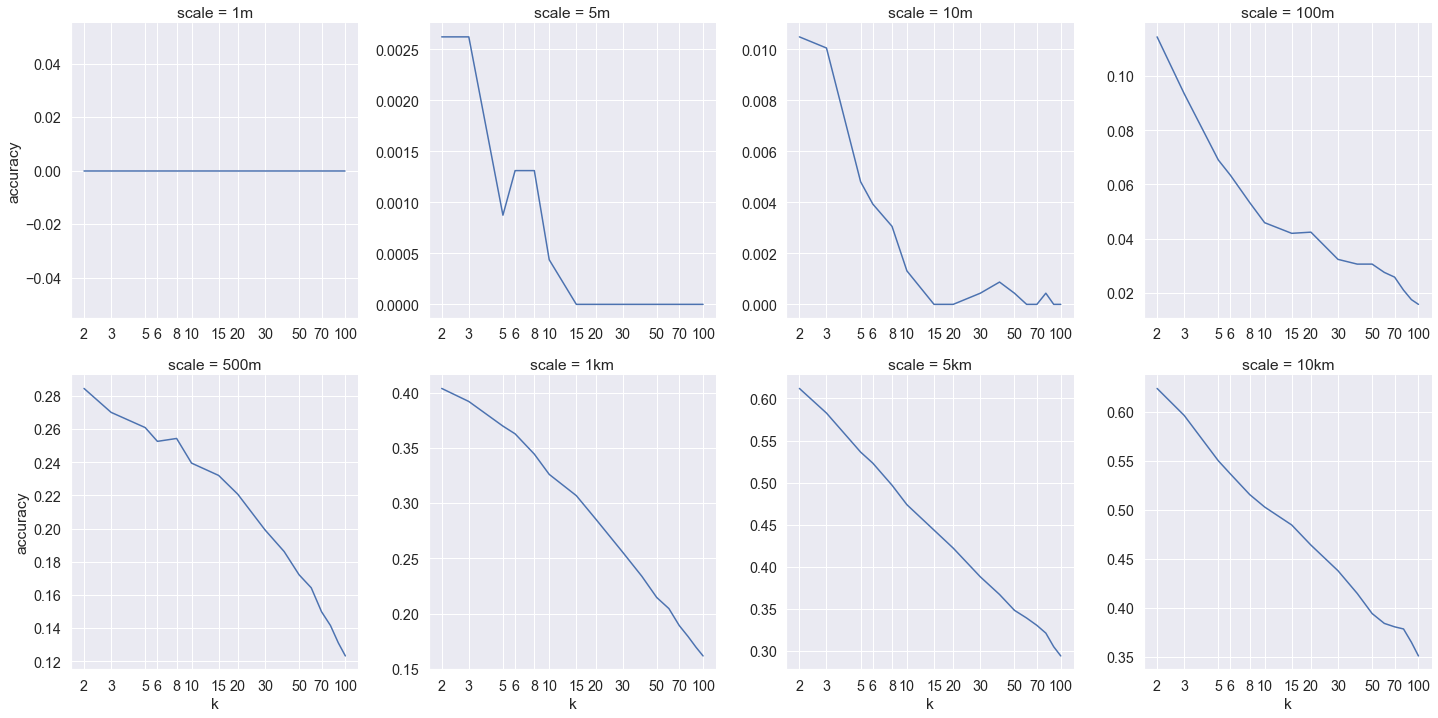

In [76]:
g= sns.relplot(
    data=avg_df_cos,
    x='k', y='accuracy', col='scale', col_wrap=4,
    kind='line', facet_kws={'sharey':False, 'sharex':False},
    palette=sns.color_palette('tab10',7),
)
g.set(xscale="log")
for ax in g.axes.flat:
    ax.set_xticks([2,3,5,6,8,10,15,20,30,50,70,100])
    ax.set_xticklabels([2,3,5,6,8,10,15,20,30,50,70,100])

In [77]:
max_accuracy = avg_df_cos.groupby(['scale'])['accuracy'].transform(max) == avg_df_cos['accuracy']
avg_df_cos[max_accuracy]

,k,scale,accuracy
0,2,1m,0.000000
1,2,5m,0.002622
2,2,10m,0.010490
3,2,100m,0.114510
4,2,500m,0.284528
5,2,1km,0.403846
6,2,5km,0.611888
7,2,10km,0.624126
8,3,1m,0.000000
9,3,5m,0.002622


## Weighted average with L2

In [53]:
with open("/Users/zakharca/Documents/Study/thesis/src/results/simple-localisation-params-finetuning/weighted_avg_val_reults.json", 'r') as f:
    w_avg_data = json.load(f)

In [64]:
data = []
Record = make_dataclass('Record', [('k', int), ('m', int),('scale', str), ('accuracy', float)])
for it in w_avg_data:
    k=it['parameters']['k']
    m=it['parameters']['m']
    for scale,acc in it['results']['accuracy'].items():
        data.append(Record(k,m,scale,acc))
w_avg_df = pd.DataFrame(data)

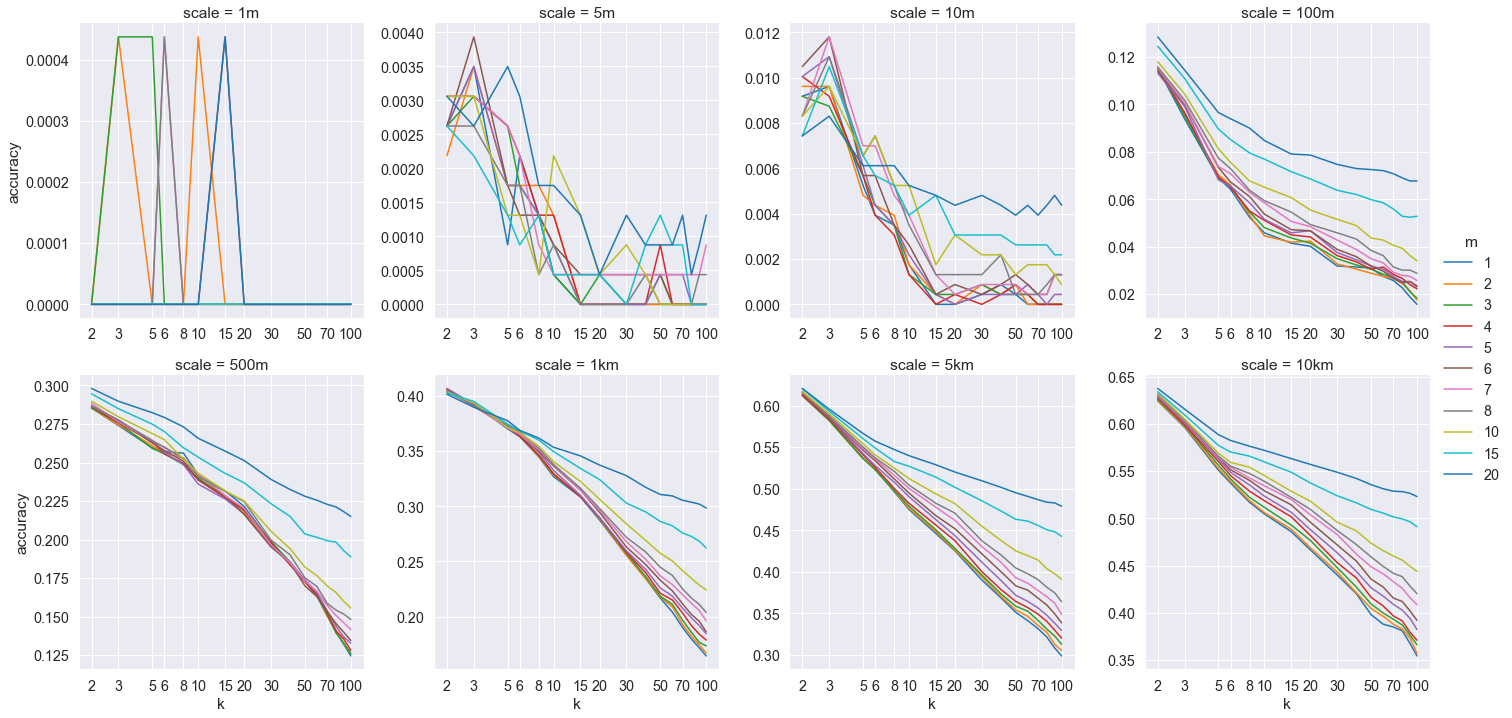

In [72]:
import matplotlib.ticker as ticker
g= sns.relplot(
    data=w_avg_df,
    x='k', y='accuracy', col='scale', hue='m', col_wrap=4,
    kind='line', facet_kws={'sharey':False, 'sharex':False},
    palette=sns.color_palette('tab10',11),
)
g.set(xscale="log")
for ax in g.axes.flat:
    ax.set_xticks([2,3,5,6,8,10,15,20,30,50,70,100])
    ax.set_xticklabels([2,3,5,6,8,10,15,20,30,50,70,100])


In [67]:
max_accuracy = w_avg_df.groupby(['scale'])['accuracy'].transform(max) == w_avg_df['accuracy']
w_avg_df[max_accuracy]

,k,m,scale,accuracy
37,2,5,1km,0.406906
83,2,20,100m,0.128497
84,2,20,500m,0.298077
86,2,20,5km,0.620629
87,2,20,10km,0.637675
96,3,2,1m,0.000437
104,3,3,1m,0.000437
129,3,6,5m,0.003934
130,3,6,10m,0.011801
138,3,7,10m,0.011801


## Weighted average with Cosine

In [83]:
with open("/Users/zakharca/Documents/Study/thesis/src/results/simple-localisation-params-finetuning/weighted_avg_cosine_1.json", 'r') as f:
    w_avg_data_cos = json.load(f)

In [84]:
data = []
Record = make_dataclass('Record', [('k', int), ('m', int),('scale', str), ('accuracy', float)])
for it in w_avg_data_cos:
    k=it['parameters']['k']
    m=it['parameters']['m']
    for scale,acc in it['results']['accuracy'].items():
        data.append(Record(k,m,scale,acc))
w_avg_df_cos = pd.DataFrame(data)

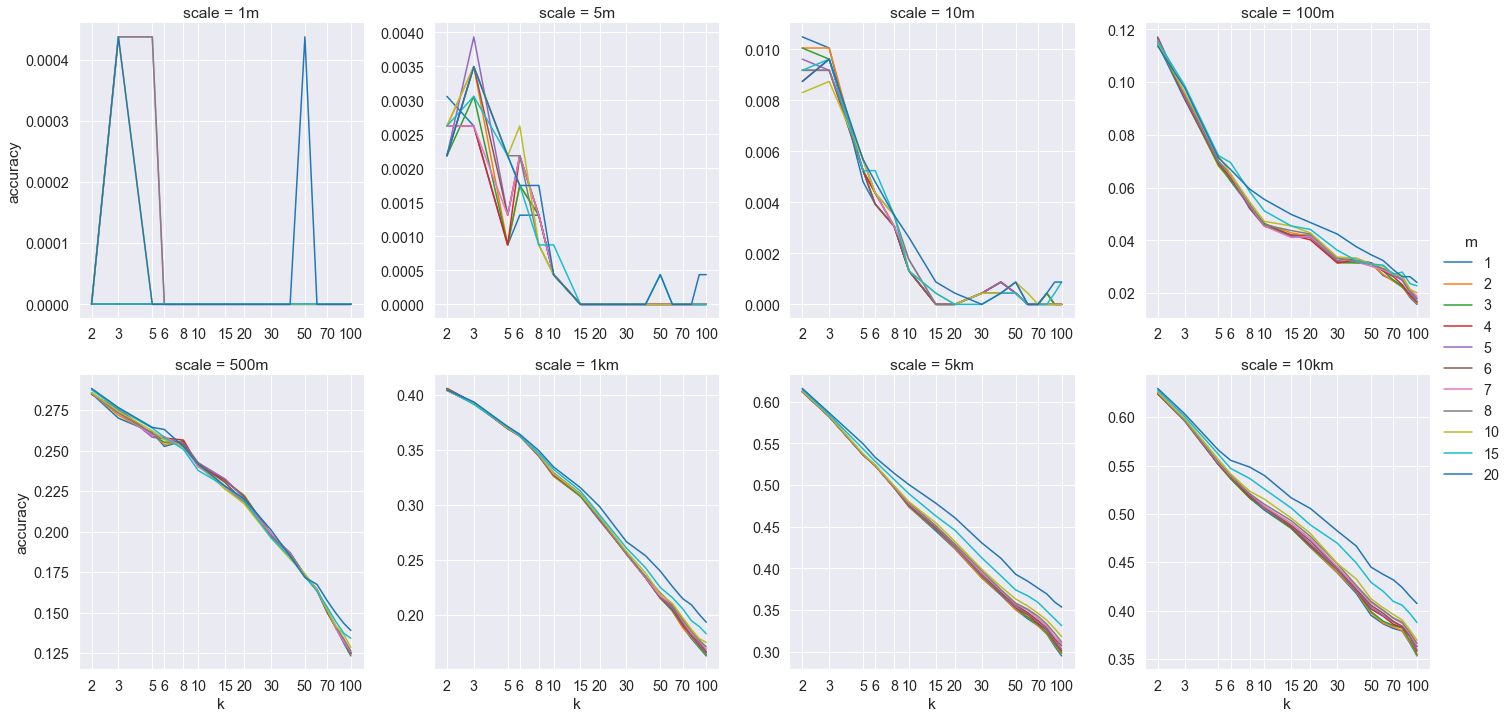

In [85]:
g= sns.relplot(
    data=w_avg_df_cos,
    x='k', y='accuracy', col='scale', hue='m', col_wrap=4,
    kind='line', facet_kws={'sharey':False, 'sharex':False},
    palette=sns.color_palette('tab10',11),
)
g.set(xscale="log")
for ax in g.axes.flat:
    ax.set_xticks([2,3,5,6,8,10,15,20,30,50,70,100])
    ax.set_xticklabels([2,3,5,6,8,10,15,20,30,50,70,100])

In [86]:
max_accuracy = w_avg_df_cos.groupby(['scale'])['accuracy'].transform(max) == w_avg_df_cos['accuracy']
w_avg_df_cos[max_accuracy]

,k,m,scale,accuracy
2,2,1,10m,0.010490
21,2,3,1km,0.405594
29,2,4,1km,0.405594
35,2,5,100m,0.117133
84,2,20,500m,0.288462
86,2,20,5km,0.615822
87,2,20,10km,0.629808
121,3,5,5m,0.003934
136,3,7,1m,0.000437
144,3,8,1m,0.000437
